In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [13]:
traing_dict = np.load("first_traing_dict.npy",encoding="bytes").item()

In [15]:
traing_dict.keys()

dict_keys([b'training_class', b'training_regress', b'training_x'])

In [29]:
training_x = traing_dict[b'training_x']

In [28]:
training_regress = traing_dict[b'training_regress']

In [30]:
training_class = traing_dict[b'training_class']

In [31]:
training_dict = {
    "training_x": training_x,
    "training_regress": training_regress,
    "training_class":training_class
}

In [32]:
!pwd

/home/zhejun/Neural_Network/Build_training


In [33]:
np.save("training_dict.npy", traing_dict)

In [9]:
y_orientation = traing_dict['training_regress']

In [24]:
a = {"a":3, "b":4}

In [25]:
a.keys()

dict_keys(['a', 'b'])

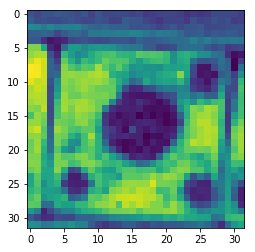

In [12]:
plt.imshow(X[0])

In [34]:
mask = np.isnan(training_regress)

In [35]:
regress_x = np.array(training_x)[~mask]

In [36]:
regress_y = np.array(training_regress)[~mask]

In [18]:
len(regress_y)

778

(array([98., 86., 81., 86., 54., 81., 61., 71., 80., 80.]),
 array([4.70829010e-03, 6.32456589e-01, 1.26020489e+00, 1.88795319e+00,
        2.51570148e+00, 3.14344978e+00, 3.77119808e+00, 4.39894638e+00,
        5.02669468e+00, 5.65444298e+00, 6.28219128e+00]),
 <a list of 10 Patch objects>)

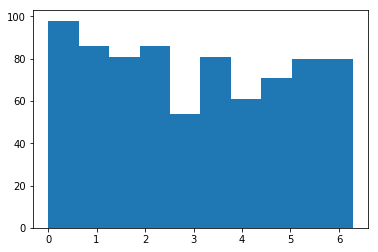

In [37]:
plt.hist(regress_y)